In [1]:
import os 

os.chdir('/Users/anatolii.stehnii/Projects/rus-poem-generator')

In [2]:
from word_forms import Phonetic

ph = Phonetic('data/words_accent.json.bz2')

In [10]:
data = [(word.lower(), ph.syllables_count(word), accent_num) for word, accent_num in ph.accents_dict.items() if ph.syllables_count(word) > 0]
data[:10]

[('жечь', 1, 1),
 ('выжечь', 2, 1),
 ('возжечь', 2, 2),
 ('зажечь', 2, 2),
 ('дожечь', 2, 2),
 ('нажечь', 2, 2),
 ('обжечь', 2, 2),
 ('ожечь', 2, 2),
 ('пережечь', 3, 3),
 ('прижечь', 2, 2)]

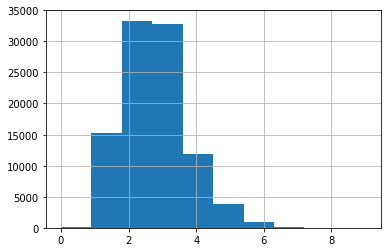

In [11]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame(data=data, columns=['word', 'count', 'accent'])
df.accent.hist()

In [13]:
# symbols vocabulary
PAD_token = '|'

PAD_idx = 0

class CharVocab:
    def __init__(self):
        self.index2char = {
            PAD_idx: PAD_token
        }
        self.char2index = {v: k for k, v in self.index2char.items()}

    def index_word(self, word):
        for char in set(word):
            self.index_char(char)

    def index_char(self, char):
        if char not in self.char2index:
            n_chars = len(self)
            self.char2index[char] = n_chars
            self.index2char[n_chars] = char
            
    def word_to_index(self, word):
        return [self.char2index[c] for c in word]

    def __len__(self):
        assert len(self.index2char) == len(self.char2index)
        return len(self.index2char)
    
all_words = ''.join([word for word,_,_ in data])
vocab = CharVocab()
vocab.index_word(all_words)
vocab.char2index

{'-': 28,
 'c': 13,
 '|': 0,
 'а': 1,
 'б': 2,
 'в': 14,
 'г': 21,
 'д': 25,
 'е': 32,
 'ж': 6,
 'з': 29,
 'и': 3,
 'й': 11,
 'к': 15,
 'л': 12,
 'м': 24,
 'н': 19,
 'о': 20,
 'п': 4,
 'р': 5,
 'с': 26,
 'т': 35,
 'у': 10,
 'ф': 23,
 'х': 27,
 'ц': 34,
 'ч': 22,
 'ш': 33,
 'щ': 16,
 'ъ': 8,
 'ы': 17,
 'ь': 7,
 'э': 18,
 'ю': 9,
 'я': 30,
 'ё': 31}

In [14]:
max_input_length = max(len(w) for w, _, _ in data)
n_classes = max(i for _, _, i in data) + 1
max_input_length, n_classes

(25, 10)

In [9]:
import torch

def word_to_vector(word):
    indexes = vocab.word_to_index(word)
    if len(word) < max_input_length:
        indexes += [PAD_idx]*(max_input_length-len(word))
        
    return torch.tensor(indexes)

X = torch.cat([word_to_vector(w).unsqueeze(0) for w, _ in data])
y = torch.cat([torch.tensor(s).unsqueeze(0) for _, s in data])

X.shape, y.shape

(torch.Size([98307, 25]), torch.Size([98307]))

In [45]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
indexes = torch.randperm(len(data))

X = X[indexes]
y = y[indexes]

In [46]:
train, dev = int(len(data)*0.64), int(len(data)*0.16)

X_train, X_dev, X_test = X[:train], X[train:train+dev], X[train+dev:]
y_train, y_dev, y_test = y[:train], y[train:train+dev], y[train+dev:]

In [47]:
import torch.nn as nn
import torch.nn.init as init

class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2, n_layers=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        init.normal_(self.embedding.weight, 0.0, 0.2)

        self.lstm = nn.LSTM(
            hidden_size,
            int(hidden_size/2),  # Bi-directional processing will ouput vectors of double size, therefore I reduced output dimensionality
            num_layers=n_layers,
            batch_first=True,  # First dimension of input tensor will be treated as a batch dimension
            bidirectional=True,
            dropout=dropout
        )

    # word_inputs: (batch_size, seq_length), h: (h_or_c, layer_n_direction, batch, seq_length)
    def forward(self, inputs, hidden):         
        # embedded (batch_size, seq_length, hidden_size)
        embedded = self.embedding(inputs)
        # output (batch_size, seq_length, hidden_size*directions)
        # hidden (h: (num_layers*directions, batch_size, hidden_size),
        #         c: (num_layers*directions, batch_size, hidden_size))
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batches):
        hidden = torch.zeros(2, self.n_layers*2, batches, int(self.hidden_size/2))
#         if USE_CUDA: hidden = hidden.cuda()
        return hidden
    
class StressMulticlass(nn.Module):
    def __init__(self, vocab, hidden_size, dropout, n_layers, n_classes):
        super().__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.encoder = EncoderRNN(len(vocab), hidden_size, dropout, n_layers)
        self.W = nn.Linear(hidden_size, n_classes)
        self.softmax = nn.Softmax()
        
    def forward_train(self, X):
        hidden = self.encoder.init_hidden(X.shape[0])
        # hidden (h: (num_layers*directions, batch_size, hidden_size/2),
        #         c: (num_layers*directions, batch_size, hidden_size/2))
        _, hidden = self.encoder(X, hidden)
        
        # (batch_size, hidden_size)
        h = hidden[0].permute(1,0,2).reshape(X.shape[0], self.hidden_size)
        # (batch_size, n_classes)
        pre_soft = self.W(h)
        return pre_soft
    
    def forward(self, X):
        pre_soft = self.forward_train(X)
        return self.softmax(pre_soft)

In [48]:
model = StressMulticlass(vocab, 200, 0.2, 1, n_classes)
model(X_dev[:1])

/Users/anatolii.stehnii/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/anatolii.stehnii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[ 0.1004,  0.0944,  0.1035,  0.1072,  0.1022,  0.0961,  0.0993,
          0.1042,  0.0976,  0.0951]])

In [49]:
from torch.optim import Adam

optim = Adam(model.parameters(), lr=0.0001)

In [50]:
import math

def batch_generator(batch_indices, batch_size):
    batches = math.ceil(len(batch_indices)/batch_size)
    for i in range(batches):
        batch_start = i*batch_size
        batch_end = (i+1)*batch_size
        if batch_end > len(batch_indices):
            yield batch_indices[batch_start:]
        else:
            yield batch_indices[batch_start:batch_end]

In [51]:
cross_entropy = nn.CrossEntropyLoss()

In [52]:
def accuracy(y_true, y_pred):
    _, indices = y_pred.max(1)
    return (y_true == indices).sum().item()/len(y_true)
    
score_functions = {'Accuracy': accuracy}

def score(model, X, y_true, desc='Scoring...'):
    scores = {name:0.0 for name in score_functions.keys()}
    y_pred = model(X)
    
    for name, func in score_functions.items():
        score = func(y_true, y_pred)
        scores[name] = score

    return scores

In [54]:
from tqdm import tqdm_notebook as tqdm

BATCH_SIZE = 100
training_length = len(X_train)
total_batches = int(training_length/BATCH_SIZE) + 1
indices = list(range(training_length))

early_stop_after = 10
early_stop_counter = 0
best_model = None

best_score = 0.0
scoring_metric = 'Accuracy'
scores_history = []
loss_history = []

for epoch in range(10000):
    # Training
    total_loss = 0.0
    model.train()
    for step, batch in tqdm(enumerate(batch_generator(indices, BATCH_SIZE)),
                            desc='Training epoch {}'.format(epoch+1),
                            total=total_batches):
        x = X_train[batch, :]
        y_true = y_train[batch]
        # (batch_size, n_classes)
        H = model.forward_train(x)
        loss = cross_entropy(H, y_true)

        assert loss.item() > 0

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        
    loss_history.append(total_loss/total_batches)
    print('Epoch {} training is finished, loss: {:.4f}'.format(epoch+1, total_loss/total_batches))
    
    desc = 'Validating epoch {}'.format(epoch+1)
    model.eval()
    scores = score(model, X_dev, y_dev, desc=desc)
    scores_str = '\n'.join(['{}: {:.4f}'.format(name, score) for name, score in scores.items()])
    scores_history.append(scores)

    print ('Epoch {} validation is finished.\n{}'.format(
        epoch+1, scores_str
    ))

    metric = scores[scoring_metric]

    # Early Stop
    if metric > best_score:
        early_stop_counter = 0
        print('The best model is found, resetting early stop counter.')
        best_score = metric
        best_model = model
    else:
        early_stop_counter += 1
        print('No improvements for {} epochs.'.format(early_stop_counter))
        if early_stop_counter >= early_stop_after:
            print('Early stop!')
            break

A Jupyter Widget

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/Users/anatolii.stehnii/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/anatolii.stehnii/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/anatolii.stehnii/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Epoch 1 training is finished, loss: 0.5712


/Users/anatolii.stehnii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 validation is finished.
Accuracy: 0.7735
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 2 training is finished, loss: 0.5569
Epoch 2 validation is finished.
Accuracy: 0.7778
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 3 training is finished, loss: 0.5440
Epoch 3 validation is finished.
Accuracy: 0.7819
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 4 training is finished, loss: 0.5325
Epoch 4 validation is finished.
Accuracy: 0.7842
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 5 training is finished, loss: 0.5222
Epoch 5 validation is finished.
Accuracy: 0.7872
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 6 training is finished, loss: 0.5126
Epoch 6 validation is finished.
Accuracy: 0.7898
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 7 training is finished, loss: 0.5038
Epoch 7 validation is finished.
Accuracy: 0.7927
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 8 training is finished, loss: 0.4955
Epoch 8 validation is finished.
Accuracy: 0.7949
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 9 training is finished, loss: 0.4878
Epoch 9 validation is finished.
Accuracy: 0.7973
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 10 training is finished, loss: 0.4806
Epoch 10 validation is finished.
Accuracy: 0.7985
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 11 training is finished, loss: 0.4738
Epoch 11 validation is finished.
Accuracy: 0.8004
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 12 training is finished, loss: 0.4672
Epoch 12 validation is finished.
Accuracy: 0.8023
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 13 training is finished, loss: 0.4609
Epoch 13 validation is finished.
Accuracy: 0.8034
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 14 training is finished, loss: 0.4550
Epoch 14 validation is finished.
Accuracy: 0.8062
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 15 training is finished, loss: 0.4493
Epoch 15 validation is finished.
Accuracy: 0.8083
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 16 training is finished, loss: 0.4438
Epoch 16 validation is finished.
Accuracy: 0.8097
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 17 training is finished, loss: 0.4384
Epoch 17 validation is finished.
Accuracy: 0.8114
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 18 training is finished, loss: 0.4333
Epoch 18 validation is finished.
Accuracy: 0.8131
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 19 training is finished, loss: 0.4282
Epoch 19 validation is finished.
Accuracy: 0.8141
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 20 training is finished, loss: 0.4232
Epoch 20 validation is finished.
Accuracy: 0.8153
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 21 training is finished, loss: 0.4183
Epoch 21 validation is finished.
Accuracy: 0.8155
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 22 training is finished, loss: 0.4136
Epoch 22 validation is finished.
Accuracy: 0.8156
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 23 training is finished, loss: 0.4090
Epoch 23 validation is finished.
Accuracy: 0.8158
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 24 training is finished, loss: 0.4047
Epoch 24 validation is finished.
Accuracy: 0.8175
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 25 training is finished, loss: 0.4005
Epoch 25 validation is finished.
Accuracy: 0.8186
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 26 training is finished, loss: 0.3965
Epoch 26 validation is finished.
Accuracy: 0.8191
The best model is found, resetting early stop counter.


A Jupyter Widget


Epoch 27 training is finished, loss: 0.3927
Epoch 27 validation is finished.
Accuracy: 0.8183
No improvements for 1 epochs.


A Jupyter Widget


Epoch 28 training is finished, loss: 0.3890
Epoch 28 validation is finished.
Accuracy: 0.8185
No improvements for 2 epochs.


A Jupyter Widget


Epoch 29 training is finished, loss: 0.3855
Epoch 29 validation is finished.
Accuracy: 0.8179
No improvements for 3 epochs.


A Jupyter Widget


Epoch 30 training is finished, loss: 0.3820
Epoch 30 validation is finished.
Accuracy: 0.8179
No improvements for 4 epochs.


A Jupyter Widget


Epoch 31 training is finished, loss: 0.3786
Epoch 31 validation is finished.
Accuracy: 0.8172
No improvements for 5 epochs.


A Jupyter Widget


Epoch 32 training is finished, loss: 0.3752
Epoch 32 validation is finished.
Accuracy: 0.8170
No improvements for 6 epochs.


A Jupyter Widget


Epoch 33 training is finished, loss: 0.3719
Epoch 33 validation is finished.
Accuracy: 0.8177
No improvements for 7 epochs.


A Jupyter Widget


Epoch 34 training is finished, loss: 0.3686
Epoch 34 validation is finished.
Accuracy: 0.8182
No improvements for 8 epochs.


A Jupyter Widget


Epoch 35 training is finished, loss: 0.3654
Epoch 35 validation is finished.
Accuracy: 0.8186
No improvements for 9 epochs.


A Jupyter Widget


Epoch 36 training is finished, loss: 0.3622
Epoch 36 validation is finished.
Accuracy: 0.8191
No improvements for 10 epochs.
Early stop!


In [63]:
word = "вобла"
count = ph.syllables_count(word)
count

2

In [64]:
tensor = torch.tensor(vocab.word_to_index(word)).unsqueeze(0)
tensor

tensor([[ 35,  21,  26,  17,   4]])

In [65]:
model(tensor)

/Users/anatolii.stehnii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[ 0.0926,  0.0368,  0.0560,  0.0719,  0.0564,  0.1132,  0.1971,
          0.2511,  0.0984,  0.0265]])

In [69]:
y_train[20:40]

tensor([ 2,  3,  2,  3,  4,  2,  2,  2,  2,  3,  3,  6,  3,  3,
         2,  2,  3,  5,  4,  2])